# Report project: ADAM Optimizer Notebook

This project was done in the scope of the CS-439 : Optimization for ML course. The project was done by :  
- Brioschi Riccardo 
- Mossinelli Giacomo
- Havolli Albias 

In this notebook, we focus on the analysis of the ADAM optimizer.

### Import useful libraries

In [1]:
# Import useful libraries for computation
import numpy as np

# Import torch and libraries to deal with NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Import pyhessian to deal with second order information
from pyhessian import hessian # Hessian computation
import copy

# Import useful library to visualize results
import matplotlib.pyplot as plt

# Importing the LeNet5 architecture we are going to use for our study and comparisons
from cnn_architectures import *

# Importing parameters to use with different optimizers before comparing them
import params

# Importing useful functions
from helpers import *

# Ignoring warnings to make the code more readable
import warnings
warnings.filterwarnings("ignore")

# Useful libraries to create directories
from os import makedirs
from shutil import rmtree

%load_ext autoreload
%autoreload 2

### Setting the parameters and additional variables

In [2]:
# Defininig neural network's parameters and seed for reproducibility purposes
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
IMG_SIZE = 32
N_CLASSES = 10

# Checking device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

### Loading MNIST dataset, reshaping and plotting  data (ADAM)

In [3]:
# Loading data
transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
raw_mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=False)


### Moving data to local device in order to visualize them (and use them later)

In [4]:
# Reshaping train data (from 28*28 to 32*32) for visualization purposes
train_data, train_target = reshape_train_data(raw_mnist_trainset, DEVICE)
# Reshaping test data (from 28*28 to 32*32) for visualization purposes
test_data, test_target = reshape_test_data(raw_mnist_trainset, DEVICE)

We now visualize the data, to let the reader become familiar with the data and the task.

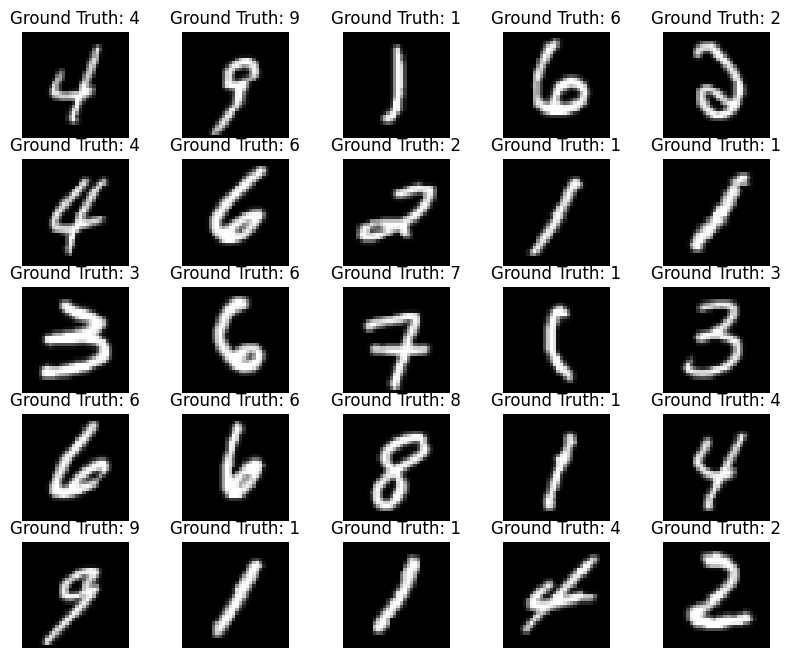

In [5]:
# Plotting some training examples with ground truth 
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_loader), size=(1,)).item()
    img = train_data[sample_idx]
    label = train_target[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Ground Truth: {}".format(train_target[sample_idx]))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model training and Model Evaluation using ADAM

First, we train our model using LeNet5. The model was trained using hyperparameters you can find in `helpers.py`. Despite the low number of training episodes and iterations, the model seems to perform well.

In [5]:
# Defining data to compute the stochastic approximation of the hessian and its eigenvalues
# along the training trajectory (the choice of the batch size is fundamental, see report)
indices = np.random.choice(len(train_data),1000) #restriction to batch size to due limited computational resources
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)
data_for_spectral_gap = [hessian_input, hessian_label]

# Initializing the model we are going to use in our study
model = LeNet5(num_classes=N_CLASSES).to(DEVICE)

# Defining the criterion (loss function) to be used during the training procedure
criterion = nn.CrossEntropyLoss()

# Defining and initializing the optimizer (ADAM in this notebook)
optimizer = torch.optim.Adam(model.parameters(), lr=params.ADAM_LEARNING_RATE)

# Adding this variable to know the number of iterations to compute in every epoch
iter_per_epoch = len(train_data) / params.ADAM_BATCH_SIZE

Let's train and test our first model.

In [6]:
model, optimizer, losses, grad_norms, spectral_gaps = training_loop(model, criterion, optimizer, train_loader, test_loader, params.ADAM_N_EPOCHS,
                                    DEVICE,data_for_spectral_gap,iter_per_epoch)

12:53:07 --- Epoch: 0	Train loss: 0.2397	Valid loss: 0.0929	Train accuracy: 97.22	Valid accuracy: 97.22
12:53:36 --- Epoch: 1	Train loss: 0.0846	Valid loss: 0.0709	Train accuracy: 98.03	Valid accuracy: 97.77
12:54:06 --- Epoch: 2	Train loss: 0.0603	Valid loss: 0.0566	Train accuracy: 98.62	Valid accuracy: 98.17
12:54:36 --- Epoch: 3	Train loss: 0.0475	Valid loss: 0.0517	Train accuracy: 99.02	Valid accuracy: 98.33
12:55:06 --- Epoch: 4	Train loss: 0.0383	Valid loss: 0.0512	Train accuracy: 99.05	Valid accuracy: 98.43
12:55:36 --- Epoch: 5	Train loss: 0.0321	Valid loss: 0.0453	Train accuracy: 99.29	Valid accuracy: 98.56
12:56:12 --- Epoch: 6	Train loss: 0.0282	Valid loss: 0.0490	Train accuracy: 99.16	Valid accuracy: 98.53
12:56:49 --- Epoch: 7	Train loss: 0.0254	Valid loss: 0.0516	Train accuracy: 99.42	Valid accuracy: 98.54
12:57:25 --- Epoch: 8	Train loss: 0.0201	Valid loss: 0.0465	Train accuracy: 99.53	Valid accuracy: 98.59
12:57:59 --- Epoch: 9	Train loss: 0.0196	Valid loss: 0.0453	Trai

We now save the model and the final results to later reproduce the plots and add them to the report.

In [7]:
makedirs('./checkpoints', exist_ok=True)
PATH = './checkpoints/adam_final_model'

torch.save(model.state_dict(), PATH + '.pt')
np.savetxt('./checkpoints/adam_grad_norms', np.array(grad_norms))
np.savetxt('./checkpoints/adam_spectral_gap', np.array(spectral_gaps))

Plot the gradient norm, which has been proven to be an important factor related to generalization properties of the architecture.

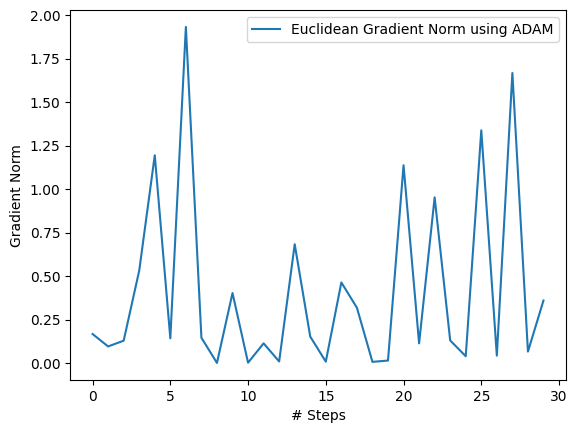

In [8]:
plot_gradient_norm(grad_norms[-30:], method = 'ADAM')

Plot the confusion matrix in order to observe the in-class accuracy.

<AxesSubplot: xlabel='Predicted label', ylabel='True label'>

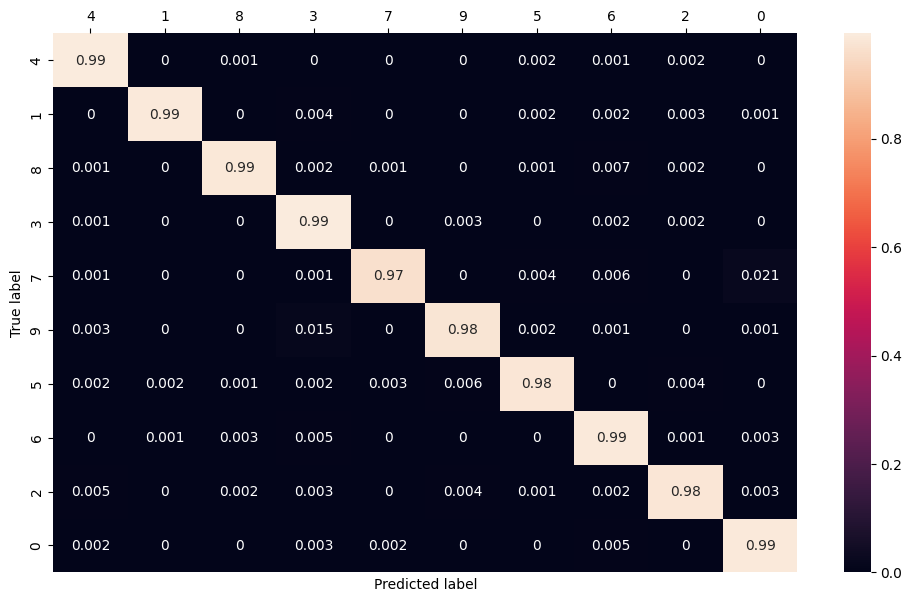

In [9]:
compute_confusion_matrix(test_loader, model, N_CLASSES)

Plot the spectral gap to discuss the possibility of introducing second order information in the last phase of the training (see report for a better explanation and for a quick overview of the limitation of this method).

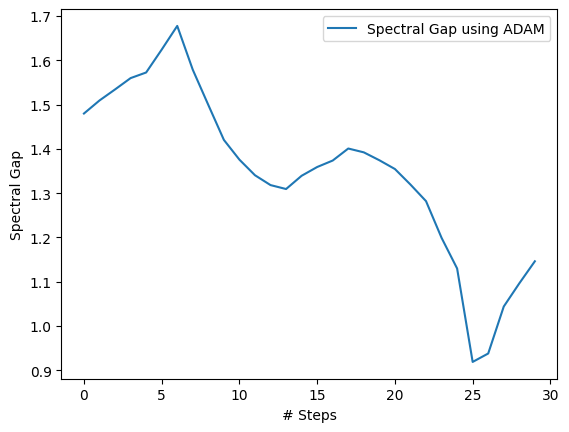

In [10]:
plot_spectral_gap(spectral_gaps, method = 'ADAM')

We now start looking at the eigenvalues in order to see whether we've reached a flat or sharp minimum. The top 2 largest and smallest eigenvalue are essential in order to observe how the second order approximation behaves in the neighborhood of the point to which we have converged (we assume, as shown in the previous plot, that the first order approximation given by the gradient is approximately zero). Notice that this analysis is different from the one provided with the spectral gap plot: here we focus on the point to which we have converged.

In [11]:
# Dividing the training dataset into batches to compute the hessian of the loss evaluated in the solution
indices = np.random.choice(len(train_data),1000)
hessian_input, hessian_label = train_data[indices].to(DEVICE), train_target[indices].to(DEVICE)


# Computing the hessian matrix, to later retrieve the spectral norm and the eigenvalues
device_flag = True if torch.cuda.is_available() else False
model_to_plot = copy.deepcopy(model)
criterion = torch.nn.CrossEntropyLoss()
hessian_comp = hessian(model_to_plot, criterion, data=(hessian_input, hessian_label), cuda=device_flag)

# Computing the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)

# Computing the top 2 eigenavlues and eigenvectors of the Hessian
print("The top eigenvalue of this model is: %.4f "% (top_eigenvalues[0]))

The top eigenvalue of this model is: 1.6940 


We now plot the loss landscape. The plot below represents how the loss behaves in the directions given by the top eigenvector (direction of maximum perturbation and maximum stretch).

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

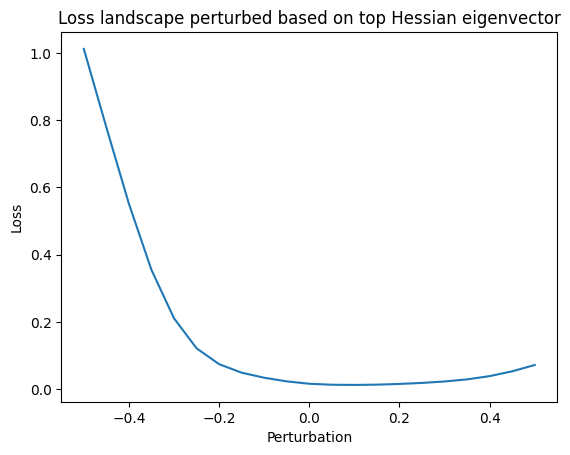

In [12]:
# Lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# At first, we initialized the perturb model to be the model obtained at the end of the training procedure
model_perb = copy.deepcopy(model)

# We now perturb the function in the direction given by the top eigenvector to visualize the quality of the minimum
for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(hessian_input), hessian_label).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

Let's save again the results :

In [13]:
np.savetxt('./checkpoints/adam_loss_list', np.array(loss_list))